In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:

filepath = '/content/drive/MyDrive/data.json'

with open(filepath, "r") as fp:
    data = json.load(fp)

In [ ]:
def plot_mfcc(mfcc, fs, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from mfccs. This is performing the same task as
    'plot_mel_spectrogram_audio' with just a different input.

    Parameters:
        mfcc (numpy.ndarray): mfccs of an audio signal
        fs (int): sampling frequency (Hz) of audio signal
        fig_size (tuple): Dimensions of figure
    """
    # Plot Spectrogram
    plt.figure(figsize=fig_size)

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    # abs on signal for better visualization
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')

    # Put a descriptive title on the plot
    plt.title('MFCCs')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

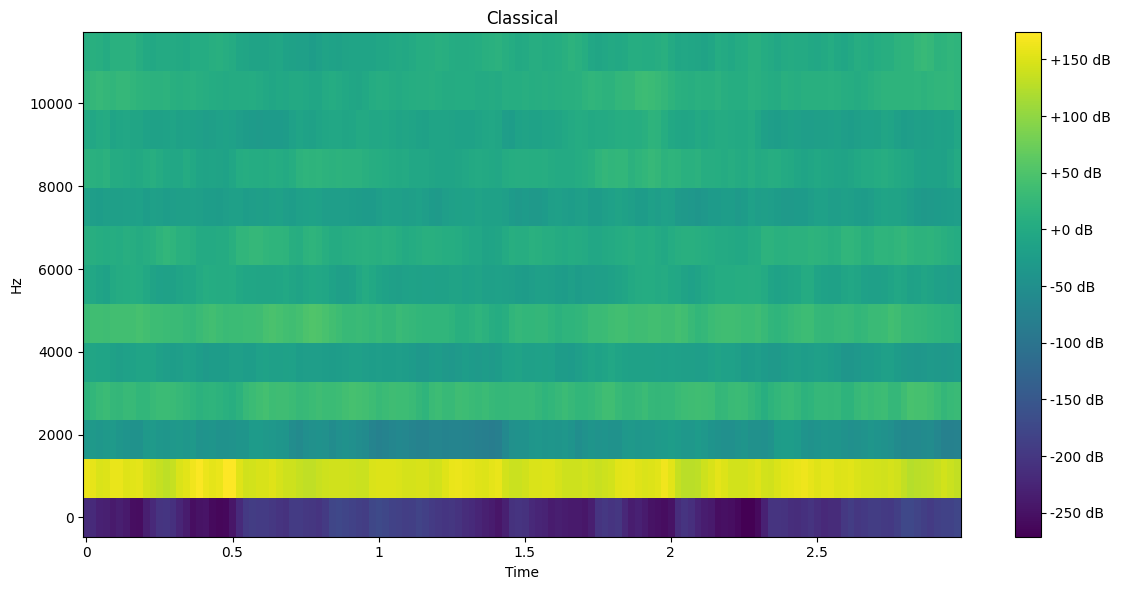

In [ ]:
idx = 1000
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");

In [ ]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

In [ ]:
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# shape = (# samples, time-bins (x), num MFCCs (y))
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (4894, 132, 13), y training data shape: (4894,)
X validation data shape: (2098, 132, 13), y validation data shape: (2098,)


In [ ]:
def plot_history(hist):
    """Plots the accuracy and loss for a model over the course of all epochs

    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)

    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")

    # Error subplot
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")

    plt.show()

In [ ]:
# Add additional dimension for CNN
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape # shape = (# samples, time-bins (x), num MFCCs (y), "channel" (like an image))

(4894, 132, 13, 1)

In [ ]:

model_cnn00 = Sequential()


model_cnn00.add(Conv2D(8, 3, activation='sigmoid', input_shape=input_shape))
model_cnn00.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn00.add(Flatten())

model_cnn00.add(Dense(10, activation='softmax'))

In [ ]:
model_cnn00.compile(optimizer=Adam(learning_rate=0.1),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:

# Train the model
hist_cnn00 = model_cnn00.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=3,
    epochs=4,
    verbose=1

)

Epoch 1/4
1632/1632 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1783 - loss: 210.0198 - val_accuracy: 0.2817 - val_loss: 131.3966
Epoch 2/4
1632/1632 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2959 - loss: 161.9160 - val_accuracy: 0.3074 - val_loss: 232.4100
Epoch 3/4
1632/1632 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3162 - loss: 172.8951 - val_accuracy: 0.2750 - val_loss: 214.2821
Epoch 4/4
1632/1632 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3320 - loss: 187.4890 - val_accuracy: 0.2822 - val_loss: 202.6190


In [ ]:
model_cnn00.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 130, 11, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 65, 6, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          31,210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,872 (366.69 KB)

 Trainable params: 31,290 (122.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,582 (244.46 KB)

In [ ]:


model_cnn01 = Sequential()

model_cnn01.add(Conv2D(8, 3, activation='sigmoid', input_shape=input_shape, padding='same'))
model_cnn01.add(MaxPooling2D(3, strides=(2,2), padding='same'))



model_cnn01.add(Conv2D(32, 3, activation='sigmoid', padding='same')) #
model_cnn01.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn01.add(Flatten())

model_cnn01.add(Dense(10, activation='softmax'))

In [ ]:
model_cnn01.compile(optimizer=Adam(learning_rate=0.01),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:


hist_cnn01 = model_cnn01.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=12,
    epochs=8,
    verbose=1

)

Epoch 1/8
408/408 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1173 - loss: 3.1900 - val_accuracy: 0.1654 - val_loss: 2.2344
Epoch 2/8
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2270 - loss: 2.1305 - val_accuracy: 0.3308 - val_loss: 1.8859
Epoch 3/8
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3307 - loss: 1.8860 - val_accuracy: 0.3356 - val_loss: 1.8451
Epoch 4/8
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3587 - loss: 1.8008 - val_accuracy: 0.3518 - val_loss: 1.7838
Epoch 5/8
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3947 - loss: 1.7019 - val_accuracy: 0.3356 - val_loss: 1.7889
Epoch 6/8
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4178 - loss: 1.6595 - val_accuracy: 0.3608 - val_loss: 1.7825
Epoch 7/8
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4085 - loss: 1.6277 - val_accuracy: 0.3575 - val_loss: 1.8526
Epoch 8/8
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4258 - loss: 1.5916 - val_accuracy: 0.3499 - v

In [ ]:
model_cnn01.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 132, 13, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 66, 7, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 66, 7, 32)           │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 33, 4, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 4224)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │          42,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,000 (523.44 KB)

 Trainable params: 44,666 (174.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 89,334 (348.96 KB)

In [ ]:

model_cnn02 = Sequential()


model_cnn02.add(Conv2D(8, 3, activation='relu', input_shape=input_shape, padding='same'))
model_cnn02.add(MaxPooling2D(3, strides=(2,2), padding='same'))


model_cnn02.add(Conv2D(16, 3, activation='relu', padding='same'))
model_cnn02.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn02.add(Conv2D(32, 3, activation='relu', padding='same'))
model_cnn02.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn02.add(Flatten())

model_cnn02.add(Dense(10, activation='softmax'))

In [ ]:
model_cnn02.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:


hist_cnn02 = model_cnn02.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=16,
    epochs=8,
    verbose=1

)

Epoch 1/8
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.2721 - loss: 4.0236 - val_accuracy: 0.3875 - val_loss: 1.6677
Epoch 2/8
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4714 - loss: 1.4129 - val_accuracy: 0.4814 - val_loss: 1.4584
Epoch 3/8
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5188 - loss: 1.2850 - val_accuracy: 0.5253 - val_loss: 1.3060
Epoch 4/8
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5829 - loss: 1.1372 - val_accuracy: 0.5520 - val_loss: 1.2516
Epoch 5/8
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6183 - loss: 1.0477 - val_accuracy: 0.5829 - val_loss: 1.1607
Epoch 6/8
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6636 - loss: 0.9556 - val_accuracy: 0.5758 - val_loss: 1.2252
Epoch 7/8
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6905 - loss: 0.8624 - val_accuracy: 0.5887 - val_loss: 1.1874
Epoch 8/8
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7220 - loss: 0.7926 - val_accuracy: 0.6111 - 

In [ ]:
model_cnn02.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)                   │ (None, 132, 13, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 66, 7, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 66, 7, 16)           │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 33, 4, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 33, 4, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 17, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │          10,890 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,336 (196.63 KB)

 Trainable params: 16,778 (65.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,558 (131.09 KB)

In [ ]:
model_cnn03 = Sequential()

model_cnn03.add(Conv2D(32, 3, activation='relu', input_shape=input_shape, padding='same'))
model_cnn03.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn03.add(Conv2D(64, 3, activation='relu', padding='same'))
model_cnn03.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn03.add(Conv2D(64, 3, activation='relu', padding='same'))
model_cnn03.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn03.add(Flatten())

model_cnn03.add(Dense(10, activation='softmax'))

In [ ]:

model_cnn03.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:


hist_cnn03 = model_cnn03.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=16,
    epochs=32,
    verbose=1

)

Epoch 1/32
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3180 - loss: 3.7539 - val_accuracy: 0.4404 - val_loss: 1.5724
Epoch 2/32
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4879 - loss: 1.3953 - val_accuracy: 0.5148 - val_loss: 1.3414
Epoch 3/32
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5668 - loss: 1.2148 - val_accuracy: 0.5772 - val_loss: 1.2307
Epoch 4/32
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6240 - loss: 1.0605 - val_accuracy: 0.6034 - val_loss: 1.1487
Epoch 5/32
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6315 - loss: 1.0076 - val_accuracy: 0.6230 - val_loss: 1.0784
Epoch 6/32
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6834 - loss: 0.8825 - val_accuracy: 0.6053 - val_loss: 1.1121
Epoch 7/32
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7062 - loss: 0.7983 - val_accuracy: 0.6187 - val_loss: 1.1703
Epoch 8/32
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7399 - loss: 0.7338 - val_accuracy: 0

In [ ]:
model_cnn03.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 132, 13, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 66, 7, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 66, 7, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 33, 4, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 33, 4, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 17, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 2176)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10)                  │          21,770 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 232,544 (908.38 KB)

 Trainable params: 77,514 (302.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 155,030 (605.59 KB)

In [ ]:
model_cnn04 = Sequential()

model_cnn04.add(Conv2D(32, 3, activation='relu', input_shape=input_shape, padding='same'))
model_cnn04.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn04.add(Conv2D(64, 3, activation='relu', padding='same'))
model_cnn04.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn04.add(Conv2D(64, 3, activation='relu', padding='same'))
model_cnn04.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn04.add(Flatten())
model_cnn04.add(Dense(64, activation='relu'))

model_cnn04.add(Dense(10, activation='softmax'))

In [ ]:
model_cnn04.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

In [ ]:

hist_cnn04 = model_cnn04.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=128,
    verbose=1
)

Epoch 1/128
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - acc: 0.1543 - loss: 8.8743 - val_acc: 0.3008 - val_loss: 2.3263
Epoch 2/128
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.2995 - loss: 2.2427 - val_acc: 0.3594 - val_loss: 1.9567
Epoch 3/128
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.3717 - loss: 1.8529 - val_acc: 0.3923 - val_loss: 1.7417
Epoch 4/128
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.4286 - loss: 1.6441 - val_acc: 0.4342 - val_loss: 1.6005
Epoch 5/128
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.4709 - loss: 1.4599 - val_acc: 0.4519 - val_loss: 1.5878
Epoch 6/128
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.5119 - loss: 1.3643 - val_acc: 0.4871 - val_loss: 1.4282
Epoch 7/128
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.5468 - loss: 1.2892 - val_acc: 0.5010 - val_loss: 1.4015
Epoch 8/128
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.5623 - loss: 1.2263 - val_acc: 0.5153 - val_loss: 1.3625
Epoch 9/128
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.591

In [ ]:
model_cnn05 = Sequential()

model_cnn05.add(Conv2D(32, 3, activation='relu', input_shape=input_shape, padding='same'))
model_cnn05.add(Conv2D(32, 3, activation='relu', padding='same'))
model_cnn05.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn05.add(Dropout(0.3))

model_cnn05.add(Conv2D(64, 3, activation='relu', padding='same'))
model_cnn05.add(Conv2D(64, 3, activation='relu', padding='same'))
model_cnn05.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn05.add(Dropout(0.3))

model_cnn05.add(Conv2D(128, 3, activation='relu', padding='same'))
model_cnn05.add(Conv2D(128, 3, activation='relu', padding='same'))
model_cnn05.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn05.add(Dropout(0.4))

model_cnn05.add(Flatten())
model_cnn05.add(Dense(128, activation='relu'))
model_cnn05.add(Dropout(0.5))

model_cnn05.add(Dense(10, activation='softmax'))

model_cnn05.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)


In [ ]:

# Train the model
hist_cnn05 = model_cnn05.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1

)

Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - acc: 0.1161 - loss: 3.9394 - val_acc: 0.2188 - val_loss: 2.2827
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - acc: 0.1392 - loss: 2.2871 - val_acc: 0.1973 - val_loss: 2.1846
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.1803 - loss: 2.1907 - val_acc: 0.2383 - val_loss: 2.0327
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.2111 - loss: 2.1130 - val_acc: 0.2936 - val_loss: 1.9608
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.2638 - loss: 2.0157 - val_acc: 0.2989 - val_loss: 1.8764
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.2838 - loss: 1.9211 - val_acc: 0.3241 - val_loss: 1.7903
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.3077 - loss: 1.8689 - val_acc: 0.3570 - val_loss: 1.7499
Epoch 8/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.3216 - loss: 1.8346 - val_acc: 0.3808 - val_loss: 1.6741
Epoch 9/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - 